In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%capture --no-stdout --no-display

from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import (Embedding, TimeDistributed, Dense,
                          Input, LSTM, Activation, Lambda)
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import Sequence

from mosestokenizer import MosesTokenizer, MosesDetokenizer

from IPython.display import HTML, display
from pprint import pprint

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import re
import io
import os
import util
import gc

# Reproducing Sutskever et al.'s results from "Sequence to Sequence Learning"
John Trimble <trimblej@gmail.com>

## Introduction

In this notebook, we attempt to reproduce Sutskever et al.'s (2014) neural machine translation model and results on the ntst14 dataset for a single model (i.e. not the results for the ensemble networks). We focus on the modifications of the model to make it trainable on a single 8GB GPU and the implementation details of building the model, training it, and producing translations. Since we will be referring to Sutskever et al. (2014) quite frequently throughout this notebook, for brevity's sake we will simply use the first author's name without a date when citing it going forward. 

## Modifications

Sutskever used an input vocabulary size of 160,000 words and an output vocabulary size of 80,000 words, each word having an embedding of 1,000 parameters. This poses two challenges: memory use and runtime performance.

Assuming we use float32 for the embedding parameters and the same vocabulary sizes as Sutskever, our embeddings would take up the following amount of memory:

$$
(160,000 + 80,000) \cdot (1,000 \text{ parameters}) \cdot (\frac{4 \text{ bytes}}{1 \text{ parameter}}) \cdot (\frac{1 \text{ GB}}{1,024^3 \text{ bytes}}) \approx 0.9 \text{ GB}
$$

While this does not seem like a substantial amount of memory, between the other parameters of the model, and the need to also fit the current training batch in GPU memory, this is somewhat more memory than we can afford on an 8GB GPU.

To understand how large vocabulary sizes cause performance issue with softmax, lets reexamine how softmax works:

$$
\sigma (z)_j = \frac{e^{z_j}}{\Sigma_{k=1}^{K} e^{z_{k}}} \text{ where } z = \theta^{T} a_{prev}
$$

Softmax requires two most unfortunate operations. First, it requires a giant sum, $\Sigma_{k=1}^{K} e^{z_{k}}$, used to normalize logits so that they form a valid probability distribution summing to 1. With Sutskever's output vocabulary of 80,000, we have a sum over 80,000 numbers (i.e. $K=80,000$). Second, a gargantuan dot product between the output of the last hidden state, $a_{prev}$, and softmax layer's weight matrix, $\theta$. With Sutskever using a batch size of 128, we have a dot product between a $(80,000 \times 1,000)$ and a $(1,000 \times 128)$ matrix. The sheer magnitude of this dot product turns out to have significant and detrimental implications for performance. See Chen et al. (2015) for a more extensive overview of these issues.

Sutskever gets around these problems by using 8 GPUs to train their model, 4 of which are dedicated to the softmax layer. However, we only have access to a single 8GB GPU. Given that, the most expedient remedy to both the memory and runtime performance issues is to simply halve the vocabulary size. So instead of using 160,000 words for the input vocabulary, we use 80,000, and instead of 80,000 words for the output vocabulary, we use 40,000:

In [3]:
MAX_ENGLISH_VOCAB=80000
MAX_FRENCH_VOCAB=40000

This may seem drastic, and it does have implications for translation accuracy, but it turns out, by way of Zipf's law (Zipf, 1949), that the top 10,000 most frequent words account for the vast majority of words used. We can see this by plotting how much of the training data is covered as the vocabulary size is increased:

In [4]:
word_counts_source, word_counts_target = util.load_word_counts(cache_dir='./target', overwrite=False)

In [5]:
def percent_data_covered_by_vocab_size(word_counts):
    word_counts_sorted = list(sorted(map(lambda x: x[1], 
                                         filter(lambda x: not x[0] in [util.SOS_IDX, util.EOS_IDX],
                                                word_counts.items())), 
                                     reverse=True))
    total = sum(word_counts_sorted)
    frequencies = [count / total for count in word_counts_sorted]
    cummulative = []
    current_percent = 0
    for percent in frequencies:
        current_percent += percent
        cummulative.append(current_percent)
    return [0.0]+cummulative

In [6]:
cummulative_coverage_source = percent_data_covered_by_vocab_size(word_counts_source)
cummulative_coverage_target = percent_data_covered_by_vocab_size(word_counts_target)

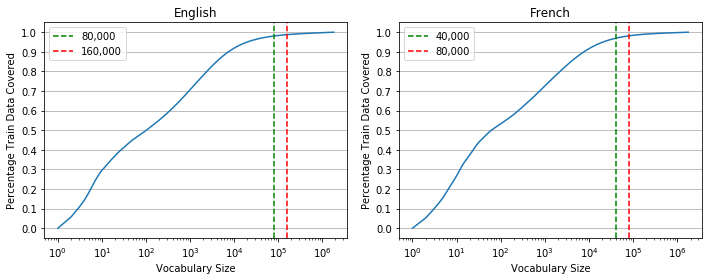

In [7]:
def plot_word_counts(cummulative_coverage_source, cummulative_coverage_target):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('English')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Percentage Train Data Covered')
    plt.semilogx(list(range(1, len(cummulative_coverage_source) + 1)), 
                 cummulative_coverage_source)
    plt.axvline(80000, color='g', linestyle='--', label="80,000")
    plt.axvline(160000, color='r', linestyle='--', label="160,000")
    plt.legend()
    plt.grid(axis='y')
    plt.yticks(np.arange(0.0, 1.01, 0.1))
    
    plt.subplot(1, 2, 2)
    plt.title('French')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Percentage Train Data Covered')
    plt.semilogx(list(range(1, len(cummulative_coverage_target) + 1)), 
                 cummulative_coverage_target)
    plt.axvline(40000, color='g', linestyle='--', label="40,000")
    plt.axvline(80000, color='r', linestyle='--', label="80,000")
    plt.legend()
    plt.grid(axis='y')
    plt.yticks(np.arange(0.0, 1.01, 0.1))
    
    plt.tight_layout()
    plt.show()

plot_word_counts(cummulative_coverage_source, cummulative_coverage_target)

Notice that with a vocabulary size of 10,000, well over 90% of the data is covered, and we begin to see diminishing returns in increasing the vocabulary size further. We can see below that the benefit of an English vocabulary size of 160,000 versus 80,000 amounts to less than a 1% difference in the amount of data out-of-vocabulary. As for the French vocabulary size, the difference between 80,000 versus 40,000 amounts to less than 1.5%:

In [8]:
print("English Train Coverage 80,000 words:  %.3f" % cummulative_coverage_source[80000])
print("English Train Coverage 160,000 words: %.3f" % cummulative_coverage_source[160000])
print("Delta: %.3f" % (cummulative_coverage_source[160000-1] - cummulative_coverage_source[80000]))
print()
print("French Train Coverage 40,000 words: %.3f" % cummulative_coverage_target[40000])
print("French Train Coverage 80,000 words: %.3f" % cummulative_coverage_target[80000])
print("Delta: %.3f" % (cummulative_coverage_target[80000] - cummulative_coverage_target[40000]))

English Train Coverage 80,000 words:  0.981
English Train Coverage 160,000 words: 0.988
Delta: 0.007

French Train Coverage 40,000 words: 0.969
French Train Coverage 80,000 words: 0.981
Delta: 0.012


The next issue is the batch size. Sutskever uses a batch size of 128. Unfortunately, for longer sentences, it becomes difficult to fit an entire training batch into GPU memory with this batch size. Consequently, we vary the batch size by sentence length to accommodate the memory constraints of a single GPU with 8GB of memory. For example, for a batch of sentences with lengths between 20 and 30 words, we use a batch size of 128, but for a batch of sentences between 100 and 120 words, we use a batch size of 32. Also, we cap sentence lengths at 120 words. Few samples are longer than this, so little training data is lost and some memory is saved:

In [9]:
thresholds = [20, 30, 40, 50, 60, 80, 100, 120]
threshold_to_batch_size = {
    20: 128,
    30: 128,
    40: 64,
    50: 64,
    60: 64,
    80: 32,
    100: 32,
    120: 32
}

With these modifications, we can train Sutskever's model on a single 8GB GPU.

## CSLM Data

The CSLM data set (Schwenk, 2014) provides a tokenized corpus of, among other things, English and French bitexts suitable for training a machine translation model. In particular, we use ep7_pc45, nc9, dev08_11, crawl, ccb2_pc30, and un2000_pc34 bitexts as our training data. Bitexts ntst1213 and ntst14 as our dev and test sets respectively. We use `<unk>`, `<s>` and `</s>` for the out-of-vocabulary (OOV), start-of-sentence (SOS), and end-of-sentence (EOS) tokens respectively.

In [10]:
word_index_source = util.load_source_word_index(cache_dir='./target', overwrite=False)
word_index_target = util.load_target_word_index(cache_dir='./target', overwrite=False)
index_word_source = {i: w for (w, i) in word_index_source.items()}
index_word_target = {i: w for (w, i) in word_index_target.items()}

In [11]:
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = util.load_data(MAX_ENGLISH_VOCAB, 
                                                                      MAX_FRENCH_VOCAB, 
                                                                      reverse_source=True, 
                                                                      cache_dir='./target', 
                                                                      overwrite=False)

Notice that, like Sutskever, we reverse the order of the English sentences, but not the French sentences, to improve the accuracy of our model:

In [12]:
print(' '.join([index_word_source[idx] for idx in X_train[80006]]))
print(' '.join([index_word_target[idx] for idx in y_train[80006]]))

</s> . <unk> <unk> and Tom , Philippines the in arrival his after month one barely Just
Tout juste un mois après son arrivée aux Philippines , Tom <unk> <unk> . </s>


Words are indexed according to their frequency such that words with higher frequency have indices lower than those with lower frequency. The exceptions being `<unk>`, `<s>`, and `</s>`, which for convenience, always have indices 1, 2, and 3. Also, in Keras, index 0 is reserved for the purpose of masking. For example, here are the 15 most frequent English words in our training data:

In [13]:
print(', '.join("'" + index_word_source[i] + "'" for i in range(4,19)))

'the', ',', 'of', '.', 'and', 'to', 'in', 'a', '(', ')', 'for', 'is', 'The', 'on', 'that'


and the 15 least frequent words:

In [14]:
highest_index_source = sorted(index_word_source.keys(), reverse=True)[0]
print(', '.join("'" + index_word_source[highest_index_source - i] + "'" for i in range(0, 15)))

'50,008,325', 'accessaccessible', 'fifth-sixth', '273,375,000', '546,750,000', 'EUR3.3', 'EUR21.2', '1,467,500', 'AfghanTemplate.htm.', 'SUSU', '105-year', '67,179', 'MISC.30.', 'MISC.14-FCCC', 'assistance.16'


Indexing words in this way makes it trivial to change the vocabulary size without having to re-index all of the words in the vocabulary as we can simply replace any indices above our vocabulary size with the OOV token as we've done when loading the CSLM data above. For comparison, here are the 15 least frequent words given our vocabulary size `MAX_ENGLISH_VOCAB`:

In [15]:
highest_index_source = max(max(tokenized_sentence) for tokenized_sentence in X_train)
print(', '.join("'" + index_word_source[highest_index_source - i] + "'" for i in range(0, 15)))

'Inmate', 'Tanger', 'GOVERNANCE', 'symbolising', '2051', 'in-orbit', 'MPM', 'Plante', 'Mays', 'Guérin', 'dampness', 'Tetouan', 'Heerlen', 'Voted', 'Collar'


Notice how much more word-like the least frequent words within the vocabulary size are versus the least common words overall.

Some additional work needs to be performed on this data before it is ready for training the model. The model requires as input: encoder inputs and decoder inputs. It also requires the labels. The encoder inputs are effectively the source sentences. The decoder inputs are essentially the target sentences, except prefixed by the start-of-sentence token. The labels are the target sentences. Note that the offset between the decoder inputs and the labels is because the decoder is effectively a language model where we are trying to predict the next word in a sentence. So, for time step `t`, the decoder input at `t` is the word preceding the label at `t`. 

Also, since we will be working with batches of training data, and batches are provided via tensors, all samples in a batch must have the same length. To accommodate this, we pad samples in a batch with `0` so that they are all the same length. These 0 values will be masked during training so they will not bias the loss. So do we put our padding at the beginning or the end of our samples? We want to reduce as much as possible the distance between the output of the final word in the encoder and the first word of the decoder. If we insert padding in-between the two, then the encoder must learn how to carry information over this dead space and the decoder must learn to do likewise. We can avoid this problem by simply padding the encoder inputs at the beginning, and the decoder inputs/labels at the end. Now the output of the encoder will be generated right at the final word for each source sentence sample in the batch, and the inputs for decoder will start at the beginning of each target sentence in the batch.

To accomplish the above, we use the the below `to_model_inputs_and_labels(..)` function:

In [16]:
def to_model_inputs_and_labels(X, y):
    X_padded_array = pad_sequences(X,
                                   dtype='int32',
                                   padding='pre',
                                   truncating='post',
                                   value=0)
    y_padded_array = pad_sequences(y,
                                   dtype='int32',
                                   padding='post',
                                   truncating='post',
                                   value=0)
    decoder_inputs = np.roll(y_padded_array, shift=1, axis=1)
    decoder_inputs[:, 0] = util.SOS_IDX
    decoder_inputs[decoder_inputs == util.EOS_IDX] = 0
    return ((X_padded_array, decoder_inputs), y_padded_array)

In [17]:
model_input_and_labels_example = to_model_inputs_and_labels(X_train[80006:80008], y_train[80006:80008])
((encoder_input_example, decoder_input_example), labels_example) = model_input_and_labels_example

Notice that samples for encoder inputs are padded on the left:

In [18]:
print("example encoder inputs:")
print(encoder_input_example)

example encoder inputs:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     3     7     1     1     8  9711     5  2904
      4    10  2791   107   200  1461    58  9916  3131]
 [    3     7     1 20965  2701     1     6  6714     4 14827   425    29
      8   540     6  2590     4    17    76  2154    57    41    71    17
    505  3045    11    29    20  9093     4 65136    20]]


Notice that samples for the decoder inputs are padded on the right and that the decoder inputs are the same as the labels except prefixed by the `<s>` token (which has index 2):

In [19]:
print("example decoder inputs:")
print(decoder_input_example)
print()
print("example decoder labels:")
print(labels_example)

example decoder inputs:
[[    2  1055  1133    18   379   157    59  1759    34  2867     5 10982
      1     1     6     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    2    27     1     9     1    27    25    48    88     9  1135  2129
      4     7    76  4612    14   717    26     7   174     4     7   658
     28    85     5   932    75 23991    11  8161     4    74  2189     5
      7     1     8  1561 24207     1     6]]

example decoder labels:
[[ 1055  1133    18   379   157    59  1759    34  2867     5 10982     1
      1     6     3     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [   27     1     9     1    27    25    48    88     9  1135  2129     4
      7    76  4612    14   717    26     7   174     4     7   658    28
 

Now, while Keras will mask the padding values to prevent biasing the loss that does not mean that the padding values come free of computational and memory costs. For this reason, we want to limit just how many padding values are in each batch. To that end, we group together sentences that are _similar_ in length to help reduce the amount of padding we need. Sutskever sped up training by a factor of two in this way. We have already defined the thresholds we will use above.

We use a custom `Sequence` subclass, `BitextSequence`, which provides the appropriate inputs and labels for the model (i.e. it calls `to_model_inputs_and_labels(..)`), handles grouping together sentences of similar lengths, shuffling the data, and restoring the sequence, deterministically, to it's a appropriate state given the current epoch. The last capability is important for continuing training after an interruption (for example, after power loss). 

In [20]:
class BitextSequence(Sequence):
    def __init__(self, X, y, batch_size, thresholds=None, truncate=False, shuffle=False, seed=1):
        if not shuffle:
            thresholds = None
            if isinstance(batch_size, dict):
                batch_size = min(batch_size.values())
                
        if not shuffle and isinstance(batch_size, dict):
            batch_size = min(batch_size.values())

        if not thresholds:
            self.thresholds = [max(map(lambda x, y: len(x)+len(y), X, y))]
        else:
            self.thresholds = list(sorted(thresholds))
            
        if isinstance(batch_size, dict):
            self.threshold_to_batch_size = batch_size
        else:
            self.threshold_to_batch_size = {threshold: batch_size for threshold in self.thresholds}
        
        self.shuffle = shuffle
        self.truncate = truncate
        self.seed = seed
        
        self._X = X
        self._y = y
        
        self.reset()
        
    def reset(self):
        self.threshold_to_ids = util.build_threshold_to_ids(
            self._X, 
            self._y, 
            self.thresholds, 
            truncate=self.truncate)
        batch_ids = []
        for threshold in sorted(self.threshold_to_ids.keys()):
            ids = self.threshold_to_ids[threshold]
            batch_size = self.threshold_to_batch_size[threshold]
            for i in range(int(np.ceil(len(ids)/float(batch_size)))):
                batch_ids.append((threshold, i))        
        self.batch_ids = batch_ids
        self._random_state = np.random.RandomState(seed=self.seed)
        self._shuffle_data()
        
    def _shuffle_data(self):
        if self.shuffle:
            for threshold in self.thresholds:
                self._random_state.shuffle(self.threshold_to_ids[threshold])
            self._random_state.shuffle(self.batch_ids)
    
    def on_epoch_end(self):
        if self.shuffle:
            print("Iteration complete, shuffling data")
        self._shuffle_data()
            
    def __len__(self):
        return len(self.batch_ids)
    
    def __getitem__(self, index):
        (threshold, i) = self.batch_ids[index]
        batch_size = self.threshold_to_batch_size[threshold]

        # get indices for data
        indices = self.threshold_to_ids[threshold][i*batch_size:(i+1)*batch_size]

        # get inputs and labels for batch
        encoder_inputs_batch = []
        labels_batch = []
        for i in indices:
            encoder_inputs_batch.append(self._X[i])
            labels_batch.append(self._y[i])

        # decoder batch
        (encoder_inputs_batch, decoder_inputs_batch), labels_batch =  to_model_inputs_and_labels(
            encoder_inputs_batch, labels_batch)

        return (encoder_inputs_batch, decoder_inputs_batch), labels_batch

In [21]:
train_bitext_sequence = BitextSequence(X_train, y_train,
                                       batch_size=threshold_to_batch_size,
                                       thresholds=thresholds,
                                       truncate=True,
                                       shuffle=True)
dev_bitext_sequence = BitextSequence(X_dev, y_dev, 
                                     batch_size=threshold_to_batch_size,
                                     thresholds=thresholds,
                                     truncate=True,
                                     shuffle=False)
test_bitext_sequence = BitextSequence(X_test, y_test, 
                                      batch_size=threshold_to_batch_size,
                                      thresholds=thresholds,
                                      truncate=False,
                                      shuffle=False)

Below is the 20th batch from the train sequence. Notice that the output is structured the same as the output of `to_model_inputs_and_labels(..)`:

In [22]:
print("Shape of 20th batch:", [tuple([x.shape for x in train_bitext_sequence[20][0]]), 
                               train_bitext_sequence[20][1].shape])
train_bitext_sequence[20]

Shape of 20th batch: [((128, 20), (128, 20)), (128, 20)]


((array([[    0,     0,     0, ...,     5,   137,   178],
         [    0,     0,     0, ...,  7505,  7389,    16],
         [    0,     0,     0, ...,    25,  3158, 47438],
         ...,
         [    0,     0,     0, ...,     4,     9,  4584],
         [    0,     0,     0, ...,    46,     5, 19440],
         [    0,     0,     0, ...,    13,   305,    12]], dtype=int32),
  array([[    2,   217,   767, ...,     0,     0,     0],
         [    2,    13, 15188, ...,     0,     0,     0],
         [    2,   295,  1841, ...,     0,     0,     0],
         ...,
         [    2,  6429,    26, ...,     0,     0,     0],
         [    2, 23154,     5, ...,     0,     0,     0],
         [    2,   341,    17, ...,     0,     0,     0]], dtype=int32)),
 array([[  217,   767,    23, ...,     0,     0,     0],
        [   13, 15188,   445, ...,     0,     0,     0],
        [  295,  1841,     1, ...,     0,     0,     0],
        ...,
        [ 6429,    26,    13, ...,     0,     0,     0],
    

Also, observe that the sequence supports shuffling but is still deterministic:

In [23]:
train_bitext_sequence.reset()
the_20th_train_batch_epoch_1 = train_bitext_sequence[20]
train_bitext_sequence.on_epoch_end()
the_20th_train_batch_epoch_2 = train_bitext_sequence[20]

# we could get incredibly lucky here, and despite shuffling, the 20th batch 
# just happens to be the same, but lets pretend that won't happen 
assert not (np.array_equal(the_20th_train_batch_epoch_1[0][0], the_20th_train_batch_epoch_2[0][0])
           and np.array_equal(the_20th_train_batch_epoch_1[0][1], the_20th_train_batch_epoch_2[0][1])
           and np.array_equal(the_20th_train_batch_epoch_1[1], the_20th_train_batch_epoch_2[1]))

train_bitext_sequence.reset()
train_bitext_sequence.on_epoch_end()

the_20th_train_batch_epoch_2_after_reset = train_bitext_sequence[20]

assert (np.array_equal(the_20th_train_batch_epoch_2_after_reset[0][0], the_20th_train_batch_epoch_2[0][0])
        and np.array_equal(the_20th_train_batch_epoch_2_after_reset[0][1], the_20th_train_batch_epoch_2[0][1])
        and np.array_equal(the_20th_train_batch_epoch_2_after_reset[1], the_20th_train_batch_epoch_2[1]))

train_bitext_sequence.reset() # restore the state

Iteration complete, shuffling data
Iteration complete, shuffling data


In [24]:
# some constants we will need
MODEL_WEIGHTS_DIRECTORY='./model_checkpoints/model_4/'

## Building the Model

Since the output at each time-step is a probability distribution over all words in the target vocabulary, the cost function is unsurprisingly cross entropy loss. As opposed to using one-hot vectors for our labels though, which can take up a considerable amount of memory, we use a sparse cross entropy loss which enables us to just provide the word indices for the labels. Now Keras provides a `keras.losses.sparse_categorical_crossentropy(..)` function, which looks a lot like what one should use, but any such use will end in dismay and frustration when using the TensorFlow backend. The issue is that `keras.losses.sparse_categorical_crossentropy(..)` expects a normalized probability distribution (as would be produced from a softmax layer), but the `tf.nn.sparse_softmax_cross_entropy_with_logits(..)` function that it wraps expects unnormalized logits. Keras does some magic to turn the given probability distribution into something suitable for TensorFlow's `sparse_softmax_cross_entropy_with_logits(..)`, but not without consequences for the model's performance.

The issue here is that Keras's loss functions take as input the output of the model, but TensorFlow expects logits for performance an numeric stability reasons. See TensorFlow issue [#2462](https://github.com/tensorflow/tensorflow/issues/2462) for details. To resolve this, we make a `keras.Model` instance specifically for training that produces logits, instead of probabilities, as output and then combine it with the below custom loss, `sparse_cross_entropy(..)`, that appropriately wraps TensorFlow's `sparse_softmax_cross_entropy_with_logits(..)`:

In [25]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return loss

An important note about the loss function: its return value should have the same shape as the labels (`y_true`). Keras decorates the provided loss function to handle masking and weighting. Returning a scalar, as one might expect to do, will lead to confusing results. See discussion in TensorFlow issue [#17150](https://github.com/tensorflow/tensorflow/issues/17150).

In [26]:
# check shape of sparse_cross_entropy(..)
with tf.Session() as session:
    logits = np.random.random((20, 5, 1000))
    labels = np.random.randint(1000, size=(20, 5))
    loss_result = session.run(sparse_cross_entropy(labels, logits))
    assert labels.shape == loss_result.shape

The `build_train_encoder_decoder_models(..)` function returns 3 instances of `keras.Model`. The first is the model for use in training, the second and third are the encoder and decoder models used for inference. 

The training model takes batches of source and target sequences, as provided by an instance of `BitextSequence` or a call to `to_model_inputs_and_labels(..)` and outputs logits for every time-step of the target sequence.

The encoder model takes as input a batch of source sequences and outputs thought vectors for each LSTM layer. The decoder model takes thought vectors and previous word input for the target, and outputs the top 100 words next possible words for every sample. 

In [27]:
def compute_top_results(logits, beam_size):
    log_prob = tf.nn.log_softmax(logits, axis=-1)
    indices = tf.constant([[util.OOV_IDX]], dtype='int32')
    updates = tf.constant([-100000.0], dtype='float32')
    scatter = tf.scatter_nd(indices, updates, tf.shape(logits)[-1:])
    adjusted_log_prob = tf.add(log_prob, scatter)
    [values, indices] = tf.nn.top_k(adjusted_log_prob, k=beam_size, sorted=True)
    return [tf.identity(values), tf.identity(indices)]

def compute_top_results_shape(input_shape, beam_size):
    shape = tuple(list(input_shape[:-1]) + [beam_size])
    return [shape, shape]

In [28]:
def build_train_encoder_decoder_models(units_rnn_layer=1000, word_vec_dim=1000, beam_size=100):
    number_rnn_layers = 4
    
    # inputs
    encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
    decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')
    
    decoder_initial_state_inputs = []
    for i in range(number_rnn_layers):
        decoder_initial_state_inputs.append(Input(shape=(units_rnn_layer,), name="initial_state_h_%s" % i))
        decoder_initial_state_inputs.append(Input(shape=(units_rnn_layer,), name="initial_state_c_%s" % i))
        
    # param initializer
    # It is unclear if Sutskever et al. intended this initialization only for LSTM layers
    # or for the entire network. I'm assuming the latter.
    initializer = RandomUniform(minval=-0.08, maxval=0.08)
    
    # encoder layers
    source_embedding = Embedding(MAX_ENGLISH_VOCAB+1, 
                                 word_vec_dim, 
                                 mask_zero=True, 
                                 name="source_embedding", 
                                 embeddings_initializer=initializer)
    
    encoder_rnn_layers = []
    for i in range(number_rnn_layers-1):
        encoder_rnn_layers.append(LSTM(units_rnn_layer, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       name="encoder_rnn_%s" % i,
                                       kernel_initializer=initializer))
    encoder_rnn_layers.append(LSTM(units_rnn_layer, 
                                   return_state=True, 
                                   name="encoder_rnn_%s" % (number_rnn_layers-1,),
                                   kernel_initializer=initializer))
    
    
    # decoder layers
    target_embedding = Embedding(MAX_FRENCH_VOCAB+1, 
                                 word_vec_dim, 
                                 mask_zero=True, 
                                 name="target_embedding",
                                 embeddings_initializer=initializer)
    
    decoder_rnn_layers = []
    for i in range(number_rnn_layers):
        decoder_rnn_layers.append(LSTM(units_rnn_layer, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       name="decoder_rnn_%s" % i,
                                       kernel_initializer=initializer))
    
    vocab_size = MAX_FRENCH_VOCAB+1
    decoder_dense = TimeDistributed(Dense(vocab_size, 
                                          activation='linear', 
                                          name="decoder_projection", 
                                          kernel_initializer=initializer))
    
    top_results_layer = Lambda(lambda x: compute_top_results(x, beam_size=beam_size),
                               output_shape=lambda input_shape: compute_top_results_shape(input_shape, beam_size=beam_size))
    
    # build train model    
    x = source_embedding(encoder_inputs)
    
    encoder_states = []
    for encoder_rnn in encoder_rnn_layers:
        x, state_h, state_c = encoder_rnn(x)
        encoder_states.append(state_h)
        encoder_states.append(state_c)
    
    x = target_embedding(decoder_inputs)
    grouped_encoder_states = [encoder_states[i:i + 2] for i in range(0, len(encoder_states), 2)]
    for (decoder_rnn, initial_state) in zip(decoder_rnn_layers, grouped_encoder_states):
        x, _, _ = decoder_rnn(x, initial_state=initial_state)
    x = decoder_dense(x)
    
    train_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=x)
    sgd_optimizer = SGD(lr=0.7, clipnorm=5.)
    
    # This bit of hoodoo is thanks to https://github.com/tensorflow/tensorflow/issues/17150. It works around
    # a bug where Keras cannot figure out the proper output shape.
    decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
    train_model.compile(optimizer=sgd_optimizer, 
                        loss=sparse_cross_entropy, 
                        target_tensors=[decoder_target])
    
    # build encoder model
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

    # build decoder model
    x = target_embedding(decoder_inputs)
    grouped_decoder_initial_state_inputs = [decoder_initial_state_inputs[i:i + 2] 
                                            for i in range(0, len(decoder_initial_state_inputs), 2)]
    decoder_outputs = []
    for (decoder_rnn, initial_state) in zip(decoder_rnn_layers, grouped_decoder_initial_state_inputs):
        x, state_h, state_c = decoder_rnn(x, initial_state=initial_state)
        decoder_outputs.append(state_h)
        decoder_outputs.append(state_c)
    x = decoder_dense(x)
    top_values_indices = top_results_layer(x)
    
    decoder_model = Model(inputs=[decoder_inputs] + decoder_initial_state_inputs, outputs=top_values_indices + decoder_outputs)

    return (train_model, encoder_model, decoder_model)

During development, we inevitably make numerous tweaks to the model and need to reload it occasionally. To facilitate this, we need to clean up any previously created models and free GPU memory before re-instantiating the models. Accomplishing this is a bit finicky and unreliable, but short of sacrificing a goat, I don't know what else to do.

In [29]:
try:
    del inference_helper
except:
    pass

try:
    del model
except:
    pass

try:
    del encoder_model
except:
    pass

try:
    del decoder_model
except:
    pass

gc.collect()
K.clear_session()
gc.collect()

model, encoder_model, decoder_model = build_train_encoder_decoder_models()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
source_embedding (Embedding)    (None, None, 1000)   80001000    encoder_inputs[0][0]             
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, None, 1000)   40001000    decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_rn

The training model takes batches of source and target sequences, as provided by an instance of `BitextSequence`, and outputs logits for every time-step of the target sequence:

In [30]:
((encoder_input_samples, decoder_input_samples), labels) = train_bitext_sequence[20]
# model.evaluate(x=[encoder_input_samples, decoder_input_samples], y=labels)
train_model_output = model.predict([encoder_input_samples, decoder_input_samples])
print("Train model output shape:", train_model_output.shape)
train_cost_output = model.evaluate(x=[encoder_input_samples, decoder_input_samples], y=labels, verbose=0)
print("Train model cost output:", train_cost_output)

Train model output shape: (128, 20, 40001)
Train model cost output: 10.592413425445557


The encoder model takes as input a batch of source sequences and outputs each LSTM layer's output and state (these are the thought vectors). The decoder model takes thought vectors and previous word input for the target, and outputs the top 100 words next possible words for every sample:

In [31]:
((encoder_input_samples, decoder_input_samples), labels) = train_bitext_sequence[20]
encoder_input_sample = encoder_input_samples[:1]
encoder_outputs_states = encoder_model.predict(encoder_input_sample)

assert 1 == len(set([output.shape for output in encoder_outputs_states]))

print("Number of encoder outputs:", len(encoder_outputs_states))
print("Shape of each encoder output:", encoder_outputs_states[0].shape)

top_log_probs, top_word_indices, *decoder_outputs_states = decoder_model.predict(
    [np.array([util.SOS_IDX], dtype='int32')]+encoder_outputs_states)

assert 1 == len(set([output.shape for output in decoder_outputs_states]))

print("Shape of top log probabilities:", top_log_probs.shape)
print("Shape of top word indices:", top_word_indices.shape)
print("Top 10 word indices:", top_word_indices[0,0,:10])
print("Number decoder outputs for next word:", len(decoder_outputs_states))
print("Shape of each decoder output for next word:", decoder_outputs_states[0].shape)

Number of encoder outputs: 8
Shape of each encoder output: (1, 1000)
Shape of top log probabilities: (1, 1, 100)
Shape of top word indices: (1, 1, 100)
Top 10 word indices: [39664 29967   658 36703 31242 15290 25791 37068 34827  2415]
Number decoder outputs for next word: 8
Shape of each decoder output for next word: (1, 1000)


## Training the Model

We use a checkpoint callback to save the model weights at the end of each epoch. This is useful for saving progress in case training gets interrupted, and also permits us to analyze the model at different points during training:

In [32]:
model_checkpoint_filename_pattern = util.get_weight_filename_pattern(MODEL_WEIGHTS_DIRECTORY)
checkpoint_callback = ModelCheckpoint(model_checkpoint_filename_pattern, period=1, save_weights_only=True)

It can take multiple days to train the model for one iteration. Ideally, we'd like to trigger our end-of-epoch callbacks, like the one for saving weights, more frequently than that. To accomplish this, we will redefine an epoch to be a partial iteration. This will cause Keras to trigger the end-of-epoch callbacks multiple times each iteration:

In [33]:
EPOCHS_PER_ITERATION = 40

Like Sutskever, we adjust the learning rate down in later iterations during training. We start with a learning rate of `0.7` and halve the learning every half iteration after the fifth. We use a `LearningRateScheduler` callback to accomplish this, keeping in mind we are using multiple epochs per iteration:

In [34]:
def create_update_learning_rate_fn(start_lr):
    epoch_of_5th_iteration = EPOCHS_PER_ITERATION * 5
    epochs_in_half_iteration = EPOCHS_PER_ITERATION // 2
    def update_learning_rate(epoch_index, lr):
        # NOTE: We do not want to half the lr parameter. Doing so has a bad interaction with
        # with training interruption. For example, on iteration 6, we should have a lerning
        # rate of 0.175 (assuming start_lr == 0.7). However, if at the beginning of iteration
        # 6 we reload the notebook and pick up training where we left off, if we simply half
        # lr we will have a learning rate of 0.35! This is because, after restart, 
        # update_learning_rate will only be called on epochs >= the epoch training is 
        # continued from. To get around this, we rely exclusively on the epoch_index and 
        # start_lr for determing the current learning rate.
        number_times_to_halve = max(0, (epoch_index - epoch_of_5th_iteration) // epochs_in_half_iteration)
        return start_lr / (2**number_times_to_halve)
    return update_learning_rate
update_learning_rate = create_update_learning_rate_fn(0.7)
lr_callback = LearningRateScheduler(update_learning_rate, verbose=1)

In [35]:
learning_rate_iteration_5_0 = update_learning_rate(int(5.0 * EPOCHS_PER_ITERATION), None)
learning_rate_iteration_5_5 = update_learning_rate(int(5.5 * EPOCHS_PER_ITERATION), None)
learning_rate_iteration_6_0 = update_learning_rate(int(6.0 * EPOCHS_PER_ITERATION), None)
assert 0.7 == learning_rate_iteration_5_0
assert 0.35 == learning_rate_iteration_5_5
assert 0.175 == learning_rate_iteration_6_0
print("Learning rate after 5.0 iterations:", learning_rate_iteration_5_0)
print("Learning rate after 5.5 iterations:", learning_rate_iteration_5_5)
print("Learning rate after 6.0 iterations:", learning_rate_iteration_6_0)

Learning rate after 5.0 iterations: 0.7
Learning rate after 5.5 iterations: 0.35
Learning rate after 6.0 iterations: 0.175


In order to translate between `EPOCHS_PER_ITERATION` and the epochs `BitextSequence` instances expect, we wrap them with an instance of `EpochAsPartialIterationSequenceWrapper`. This wrapper will handle making calls to `on_epoch_end(..)` on our `BitextSequence` instances as appropriate and will allow us to pick up approximately where we left off if training is interrupted in the middle of an iteration:

In [36]:
train_bitext_sequence_wrapped = util.EpochAsPartialIterationSequenceWrapper(train_bitext_sequence, 
                                                                            EPOCHS_PER_ITERATION)
print("Number batches in train_bitext_sequence:", len(train_bitext_sequence))
print("Number batches in train_bitext_sequence_wrapped:", len(train_bitext_sequence_wrapped))

# Note that `on_epoch_end()` must be called `EPOCHS_PER_ITERATION` times on the 
# `EpochAsPartialIterationSequenceWrapper` instance before `on_epoch_end()` is called on 
# the underlying sequence causing it to be shuffled.
for _ in range(EPOCHS_PER_ITERATION):
    train_bitext_sequence_wrapped.on_epoch_end()
    
del train_bitext_sequence_wrapped # we'll create a new wrapper during training

Number batches in train_bitext_sequence: 146576
Number batches in train_bitext_sequence_wrapped: 3664
Iteration complete, shuffling data


Before training, we load the last saved weights and set `current_epoch` to the appropriate epoch index:

In [37]:
current_epoch=0
# load last saved weights if present
weight_file_and_epoch = util.latest_epoch_and_weights_file(MODEL_WEIGHTS_DIRECTORY)
if weight_file_and_epoch:
    weights_file, current_epoch = weight_file_and_epoch
    print("Loading weights from %s" % weights_file)
    model.load_weights(weights_file)

Loading weights from ./model_checkpoints/model_4/weights.300-1.9027-1.4531.h5


Now we begin training. Note that it took 23 days to train this model, so the next cell can take a while to run if starting from scratch. However, due to our efforts above, it should be possible to interrupt training with minimal time lost.

In [38]:
if current_epoch < int(7.5*EPOCHS_PER_ITERATION):
    train_bitext_sequence_wrapped = util.EpochAsPartialIterationSequenceWrapper(
    train_bitext_sequence,
    EPOCHS_PER_ITERATION)
    train_bitext_sequence_wrapped.switch_to_epoch(current_epoch)

    model.fit_generator(
        generator=train_bitext_sequence_wrapped,
        validation_data=dev_bitext_sequence,
        steps_per_epoch=train_bitext_sequence_wrapped.steps_per_epoch,
        shuffle=False, # our sequence type does this for us
        initial_epoch=current_epoch,
        epochs=int(EPOCHS_PER_ITERATION*7.5),
        workers=2,
        callbacks=[checkpoint_callback, lr_callback])

Now we can plot the loss on our validation and training sets: 

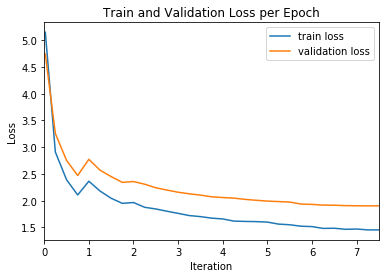

In [39]:
def plot_loss(model_weights_directory):
    model_props = [props for (f, props) in util.list_all_weight_files_and_props(model_weights_directory)]
    model_props_by_epoch = sorted(model_props, key=lambda x: x[0])
    (epoch, val_loss, loss) = zip(*model_props_by_epoch)
    epoch = [epoch / 40.0 for epoch in epoch]
    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title("Train and Validation Loss per Epoch")
    plt.xlim(0, epoch[-1])
    plt.show()
    
plot_loss(MODEL_WEIGHTS_DIRECTORY)

Note the anomaly between iterations 0.5 and 1 where the loss appears to shoot up. This is due to error in `sparse_cross_entropy(..)` above. Originally, the function returned a scalar, instead of a tensor with the same dimensions as the labels, which led Keras to incorrectly adjust the loss based on the padding. Consequently, the loss was lower than it should have been until the bug was corrected around iteration 1. 

## Generating Translations

We use a beam search to generate translations. There are a number of ways to implement beam search, in particular around the stop condition, and the specifics of how it was implemented in Sutskever are unclear. It turns out the way we have implemented it below is similar to Bahdanau et al. (2014) in that we shrink the beam length every time a candidate translation is completed until the beam length becomes zero. According to Huang et al. (2017), this approach is suboptimal, but such is life.

We use 0.7 for the sentence length normalization constant. Without normalization, beam search tends to prefer succinct, but perhaps less accurate, translations over longer, perhaps more natural, translations. If we set this constant to 0, there would be no normalization, if we set this constant to 1, the probability of a candidate translation would be divided by the number of words in the sentence--effectively eliminating sentence length as a consideration. Everything in-between, such as 0.7 as we have chosen, is a compromise between the two.

Also, another note concerning the below implementation: it is incredibly and unbelievably slow. Probably don't reuse this code. I'm sure better implementations exist.

In [40]:
#@do_profile(follow=[])
def beam_search(encoder_output_states, decoder_model, maxlen, 
                sos_token_index, eos_token_index, oov_token_index=util.OOV_IDX, 
                black_list=None,
                beam_length=10, alpha=0.7):
    
    if black_list is None:
        black_list = [oov_token_index]
    
    completed_candidates = []
    
    previous_state_arrays = encoder_output_states[:]
    decoder_inputs = np.array([[sos_token_index]])
    candidate_log_prob_sum = np.array([[0]])
    
    while len(completed_candidates) < beam_length:
        shrunk_beam_length = beam_length - len(completed_candidates)
        
        previous_token_idxs = decoder_inputs[:,-1:]
        top_log_probs, top_indices, *previous_state_arrays = decoder_model.predict([previous_token_idxs] + previous_state_arrays)
        
        # remove uneeded time dimension (since we are only looking one word at a time)
        top_log_probs = np.squeeze(top_log_probs, axis=1)
        top_indices = np.squeeze(top_indices, axis=1)
        
        # sort log probs and word indices by log prob
        sorted_indices = np.argsort(top_log_probs, axis=-1)
        top_log_probs = top_log_probs[np.arange(np.shape(top_log_probs)[0])[:,np.newaxis], sorted_indices]
        top_indices = top_indices[np.arange(np.shape(top_log_probs)[0])[:,np.newaxis], sorted_indices]

        # for each candidate, calc the sum of log probabilities for potential next words        
        candidate_top_choices_indices = top_indices[:, -shrunk_beam_length:]
        candidate_top_choices = top_log_probs[:, -shrunk_beam_length:]
        candidate_top_choices = np.add(candidate_top_choices, candidate_log_prob_sum, candidate_top_choices)
            
        # get indices of next top word choices
        indices_1d = np.argpartition(candidate_top_choices, -shrunk_beam_length, axis=None)[-shrunk_beam_length:]
        candidate_idxs, top_choices_idxs = np.unravel_index(indices_1d, candidate_top_choices.shape)
        
        # map top_choices_idxs back to the corresponding word indices
        word_idxs = candidate_top_choices_indices[candidate_idxs, top_choices_idxs]
        
        # update previous state arrays for top candidates
        previous_state_arrays = [prev[candidate_idxs,:] for prev in previous_state_arrays]
        
        # update decoder inputs for next iteration
        decoder_inputs = np.append(decoder_inputs[candidate_idxs, :], 
                                   np.array(word_idxs).reshape((len(word_idxs), 1)),
                                   axis=1)
        
        # update candidate prob based on top candidates
        candidate_log_prob_sum = candidate_top_choices[candidate_idxs, top_choices_idxs].reshape(len(candidate_idxs), 1)
        
        # extract any completed candidates
        incomplete_candidates = []
        for candidate_idx in range(len(decoder_inputs)):
            if decoder_inputs[candidate_idx][-1] == eos_token_index or decoder_inputs.shape[1] > maxlen:
                completed_candidates.append((candidate_log_prob_sum[candidate_idx], decoder_inputs[candidate_idx]))
            else:
                incomplete_candidates.append(candidate_idx)
        
        # update values accounting for completed candidates
        decoder_inputs = decoder_inputs[incomplete_candidates]
        candidate_log_prob_sum = candidate_log_prob_sum[incomplete_candidates]
        previous_state_arrays = [prev[incomplete_candidates,:] for prev in previous_state_arrays]
    
    # return candidate with highest probability accounting for sentence length normalization
    def normalize_prob_by_sentence_length(completed_candidate):
        prob, tokens = completed_candidate
        return prob / (len(tokens)**(alpha))
    
    sorted_completed_candidates = sorted(completed_candidates, 
                                         reverse=True, 
                                         key=normalize_prob_by_sentence_length)
    output_indices = sorted_completed_candidates[0]
    
    return output_indices[1][1:]

The following `InferenceHelper` class takes care of the ceremony involved in translating texts using a beam search. You can translate source texts to target texts, source sequences to target sequences, source sequences to thought vectors, and thought vectors to target sequences.

In [41]:
def assert_valid_thought_vector(thought_vector):
    assert len(thought_vector) == 8, "Expected 8 entries in thought vector but found %s" % len(thought_vector)

In [42]:
def encoder_states_to_thought_vectors(encoder_states):
    (samples, units) = encoder_states[0].shape
    thought_vectors = [[np.reshape(state, (1,units)) for state in thought_vector] 
                       for thought_vector in zip(*encoder_states)]
    assert len(thought_vectors) == samples
    return thought_vectors

In [43]:
def build_keras_tokenizer(word_index, vocab_size):
    new_word_index = {w: i for (w, i) in word_index.items() if i < vocab_size+1}
    tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=util.OOV_TOKEN)
    tokenizer.word_index = new_word_index
    return tokenizer

In [44]:
class InferenceHelper:
    def __init__(self, 
                 encoder_model, decoder_model, 
                 source_word_index, target_word_index,
                 source_vocab_size, target_vocab_size,
                 source_lang, target_lang):
        
        self.target_tokenizer = build_keras_tokenizer(target_word_index, target_vocab_size)
        self.source_tokenizer = build_keras_tokenizer(source_word_index, source_vocab_size)
        
        self.target_lang = target_lang
        self.source_lang = source_lang
        
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.target_index_to_word = {i: w for (w, i) in self.target_tokenizer.word_index.items()}
        self.source_index_to_word = {i: w for (w, i) in self.source_tokenizer.word_index.items()}
        
    def _sequences_to_texts(self, index_to_word, lang, sequences):
        with MosesDetokenizer(lang=lang) as detokenize:
            texts = ([index_to_word[i] for i in sequence if i != 0 and i != util.EOS_IDX] for sequence in sequences)
            return list(map(detokenize, texts))
    
    def _texts_to_sequences(self, keras_tokenizer, lang, texts):
        with MosesTokenizer(lang=lang) as tokenize:
            tokens_lists = list(map(lambda x: x + [util.EOS_TOKEN], map(tokenize, texts)))
            sequences = keras_tokenizer.texts_to_sequences(tokens_lists)
            return sequences

    def sequences_to_target_texts(self, sequences):
        return self._sequences_to_texts(self.target_index_to_word, self.target_lang, sequences)
    
    def sequences_to_source_texts(self, sequences):
        return self._sequences_to_texts(self.source_index_to_word, self.source_lang, sequences)
    
    def sequences_to_target_tokens(self, sequences):
        return [[self.target_index_to_word[i] for i in sequence if i != 0 and i != util.EOS_IDX] 
                for sequence in sequences]
    
    def source_sequences_to_thought_vectors(self, source_sequences):
        # From predict we get back parallel arrays for the encoder output states:
        #
        #    LSTM1_h, LSTM1_c, ..., LSTMn_h, LSTMn_c
        #
        # We want to return a list thought_vectors s.t. thought_vectors[i] 
        # returns the relevant LSTM states for source_sequences[i]. The use of
        # zip beblow achieves this.
        if not isinstance(source_sequences, np.ndarray):
            source_sequences = pad_sequences(source_sequences, 
                                             dtype='int32', 
                                             padding='pre', 
                                             value=0)
        encoder_states = self.encoder_model.predict(source_sequences)
        thought_vectors = encoder_states_to_thought_vectors(encoder_states)
        for thought_vector in thought_vectors:
            assert_valid_thought_vector(thought_vector)
        return list(thought_vectors)
    
    def translate_thought_vectors_to_target_sequences(self, thought_vectors, beam_length=100):
        # The way beam_search is implemented, we only support translating 
        # one sentence at a time. Consequently, we'll need to iterate over
        # the thought vectors and do one translation at a time.
        target_sequences = []
        for thought_vector in thought_vectors:
            assert_valid_thought_vector(thought_vector)
            sos_index = self.target_tokenizer.word_index['<s>']
            eos_index = self.target_tokenizer.word_index['</s>']
            oov_index = self.target_tokenizer.word_index[util.OOV_TOKEN]
            target_sequence = beam_search(
                thought_vector, 
                decoder_model=self.decoder_model, 
                maxlen=200,
                sos_token_index=sos_index, 
                eos_token_index=eos_index, 
                oov_token_index=oov_index, 
                beam_length=beam_length)
            target_sequences.append(target_sequence)
        return target_sequences
    
    def translate_sequences_to_sequences(self, source_sequences, beam_length=100):
        return self.translate_thought_vectors_to_target_sequences(
            self.source_sequences_to_thought_vectors(source_sequences),
            beam_length=beam_length)
    
    def translate_texts_to_texts(self, source_texts, beam_length=100):
        source = self._texts_to_sequences(self.source_tokenizer, 'en', source_texts)
        for sequence in source:
            sequence.reverse()
        target = self.translate_sequences_to_sequences(source, beam_length=beam_length)
        target_texts = self.sequences_to_target_texts(target)
        return target_texts

In [45]:
inference_helper = InferenceHelper(encoder_model, decoder_model, 
                                   word_index_source, word_index_target,
                                   MAX_ENGLISH_VOCAB, MAX_FRENCH_VOCAB,
                                   'en', 'fr')

Some example translations using `InferenceHelper`:

In [46]:
inference_helper.translate_texts_to_texts([
    "Hello!",
    "Goodbye!",
    "Green colorless ideas sleep furiously.",
    "The police officer saw the man with the telescope."
], beam_length=12)

['Bonjour !',
 'En fin de compte !',
 'Les idées vertes ont du mal à dormir.',
 "L'officier de police a vu l'homme avec le télescope."]

Below we translate a subset of the dev data. We reviewed the result of this periodically to monitor how well translations improved during training:

In [47]:
def print_translation_summary(inference_helper, X, y, line_length=120):
    # source sentences
    source_sequences = [list(s) for s in X]
    for s in source_sequences:
        s.reverse()
    source_texts = inference_helper.sequences_to_source_texts(source_sequences)

    # translations
    translated_sequences = [inference_helper.translate_sequences_to_sequences([sequence], beam_length=12)[0] 
                            for (sequence,label) in zip(X, y)]
    translated_texts = inference_helper.sequences_to_target_texts(translated_sequences)

    # labels
    label_texts = inference_helper.sequences_to_target_texts(y)
    
    # print everything
    for (source, label, translation) in zip(source_texts, label_texts, translated_texts):
        place_holder = "{0:." + str(line_length) + "s}"
        print(place_holder.format(source))
        print(place_holder.format(label))
        print(place_holder.format(translation))
        print()

In [48]:
samp_ids = util.build_threshold_to_ids(X_dev, 
                                       y_dev, 
                                       [20], 
                                       truncate=False)[20][20:40]
X_samp = [X_dev[i] for i in samp_ids]
y_samp = [y_dev[i] for i in samp_ids]
print_translation_summary(inference_helper, X_samp, y_samp, line_length=200)

Czechs qualified for EURO.
Les tchèques se sont qualifiés pour l'EURO.
Les Tchèques sont qualifiés pour l'EURO.

In Montenegro they won 1: 0 and celebrate a 200 million windfall.
Ils ont gagné au Monténégro 1 : 0 et <unk> la qualification pour 200 millions
Au Monténégro, ils ont gagné 1 : 0 et célèbrent 200 millions d'euros.

Football representation successfully managed the toughest task of the season!
La représentation du football a réussi sa plus difficile mission de la saison !
La représentation de football a réussi à gérer la tâche la plus difficile de la saison !

<unk> watched the progress match in a detailed report.
<unk> a suivi le match de qualification avec un reportage détaillé.
Les participants ont examiné les progrès accomplis dans un rapport détaillé.

<unk> and <unk> became the match's least lucky couple after losing two great opportunities.
Les <unk> du match ont été <unk> et <unk> qui ont <unk> deux chances de marquer un but.
C'est la première fois qu'il s'agit d'un de

## Measuring Translation Quality

To measure quality of translations we use BLEU scores. Unfortunately, it turns out there are numerous ways to calculate the BLEU score, so knowing the average BLEU score a model achieves does not, on its own, tell one much. Like Sutskever, we use the `multi-bleu.perl`<sup>7</sup> for calculating BLEU scores.

We want to get the BLEU score of our model on both our dev (`X_dev` and `y_dev`) and test data (`X_test` and `y_test`), which correspond to the ntst1213 and ntst14 datasets respectively. (Admittedly, this relationship is unclear, and you'd have to dig into the implementation of `util.load_data(..)` to know.) To accomplish this, we generate translations of these datasets and dump them to files suitable for consumption by `multi-bleu.perl`. We do this for both a beam size of 1 and 12 for comparison with Sutskever's results. Both the `create_tokenized_translations(..)` and `generate_tokenized_translations(..)` below facilitate this:

In [49]:
def create_tokenized_translations(inference_helper, X, beam_length, output_file):
    import time
    batch_size = 32
    with open(output_file, 'w', encoding='utf-8') as f:
        number_batches = int(np.ceil(len(X)/batch_size))
        for i in range(number_batches):
            samples = X[(i*batch_size):(i+1)*batch_size]
            target_sequences = inference_helper.translate_sequences_to_sequences(samples, beam_length=beam_length)
            target_tokenized = inference_helper.sequences_to_target_tokens(target_sequences)
            for tokenized_line in target_tokenized:
                f.write(' '.join(tokenized_line)+'\n')       

In [50]:
def generate_tokenized_translations(model, 
                                    inference_helper, 
                                    X, 
                                    dataset_name, 
                                    model_directory, 
                                    reference=None, 
                                    every_n_epochs=1, 
                                    start_at_epoch=0):
    beam_lengths = [1, 12]
    format_string = '{}.predicted.{:03d}.{}.tok'
    regex = util.convert_format_string_to_regex(format_string)
    
    # find translation files we need to generate
    params = []
    for file, (epoch, *_) in util.list_all_weight_files_and_props(model_directory):
        if epoch % every_n_epochs == 0 and epoch >= start_at_epoch:
            for beam_length in beam_lengths:
                target_file = os.path.join(
                    model_directory, format_string.format(dataset_name, epoch, beam_length))
                if not os.path.isfile(target_file):
                    params.append((epoch, beam_length, file, target_file))
    
    # generate needed translation files
    # save the weights so that we can restore them later
    old_weights = list(map(np.copy, model.get_weights()))
    try:
        for (epoch, beam_length, weights_file, target_file) in params:
            model.load_weights(weights_file)
            create_tokenized_translations(inference_helper, X, beam_length, target_file)
    finally:
        # restore the model back to where it was
        model.set_weights(old_weights)
    
    # In some cases, we may have prediction data for some epoch of the model, but not the actual
    # model weights file (the weight file may have been deleted after generating predictions to 
    # save space). Consequently, we get all the prediction files in `model_directory` and return
    # them, even if there is no constituent weight file.
    translation_files = []
    for translation_file in util.list_files_by_regex(regex, model_directory):
        m = re.fullmatch(regex, os.path.basename(translation_file))
        if m:
            (dataset, epoch, beam_length) = m.groups()
            if dataset_name == dataset:
                translation_files.append((int(epoch), int(beam_length), translation_file))
    
    return sorted(translation_files, key=lambda x: (x[0], x[1]))

Below, we make the appropriate calls to generate translations for ntst1213 and ntst14. For ntst1213, we generate translations not just for the final model, but for intermediate training states as well. This allows us to plot how the model performance improves throughout training. These calls will generate files in the `MODEL_WEIGHTS_DIRECTORY` containing the translations:

In [51]:
predictions_dev = generate_tokenized_translations(model,
                                                  inference_helper,
                                                  X_dev,
                                                  'ntst1213',
                                                  MODEL_WEIGHTS_DIRECTORY,
                                                  every_n_epochs=20)

predictions_test = generate_tokenized_translations(model,
                                                   inference_helper,
                                                   X_test,
                                                   'ntst14',
                                                   MODEL_WEIGHTS_DIRECTORY,
                                                   every_n_epochs=300,
                                                   start_at_epoch=300)

Below we calculate the the average BLEU score for the ntst1213 and ntst14 datasets:

In [52]:
def calc_bleu_scores_from_predictions(reference_filename, predictions):
    result = []
    for (epoch, beam_length, prediction_file) in predictions:
        bleu_score = util.multi_bleu(reference_filename, prediction_file)
        result.append((epoch, beam_length, bleu_score))
    return result

In [53]:
epoch_beam_bleu_dev = calc_bleu_scores_from_predictions('target/dev/ntst1213.fr', predictions_dev)
epoch_beam_bleu_test = calc_bleu_scores_from_predictions('target/dev/ntst14.fr', predictions_test)

Below we get the final BLEU score and the BLEU scores by sentence length on the ntst14 data: 

In [54]:
ntst14_final = next(filter(lambda x: x[0] == 300 and x[1] == 12, predictions_test), None)
lengths_bleu_test = None
if ntst14_final:
    length_bleu_test = util.calc_bleu_scores_by_length_thresholds('target/dev/ntst14.en',
                                                                  'target/dev/ntst14.fr',
                                                                  ntst14_final[-1],
                                                                  list(range(5, 105, 5)))

### BLEU score over training epochs

In [55]:
def plot_average_bleu_per_epoch(epoch_beam_bleu_list, labels, title, epochs_per_iteration):
    result = []
    for (epoch_beam_bleu, label) in zip(epoch_beam_bleu_list, labels):
        beam_lengths = set([beam_length for (_, beam_length, *_) in epoch_beam_bleu])
        for beam_length in beam_lengths:
            epoch_bleu = [(epoch, bleu) for (epoch, beam, bleu) in epoch_beam_bleu if beam == beam_length]
            epoch_bleu = sorted(epoch_bleu, key=lambda x: x[0])
            result.append((epoch_bleu, '{} (beam={})'.format(label, beam_length)))
            
    for epoch_bleu, label in result:
        epochs, bleu_scores = zip(*epoch_bleu)
        epochs = [epoch / epochs_per_iteration for epoch in epochs]
        plt.plot(epochs, bleu_scores, label=label)
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Bleu Score')
    plt.title(title)
    plt.xlim(1, epochs[-1])
    plt.show()

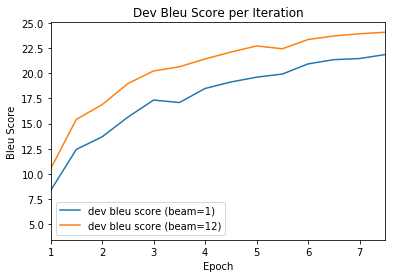

In [56]:
plot_average_bleu_per_epoch([epoch_beam_bleu_dev], ['dev bleu score'], 'Dev Bleu Score per Iteration', 40)

Consistent with the loss plot, the BLEU score improves gradually over time during training, with an unsurprisingly higher BLEU score with a beam size of 12 than of 1.

### BLEU score by sentence length

In [57]:
def plot_bleu_score_by_sentence_length(length_bleu, label, title):
    lengths, bleu_scores = zip(*length_bleu)
    range_starts = [0]
    range_starts.extend(lengths)
    plt.bar([i for i in range(len(lengths))], bleu_scores, width=1, label=label, align='edge')
    plt.legend()
    plt.xticks(range(len(range_starts)), range_starts)
    plt.xlim(0, len(range_starts)-1)
    plt.ylabel('Bleu Score')
    plt.xlabel('Source Sentence Length')
    plt.title('Bleu Score by Sentence Length')
    plt.show()

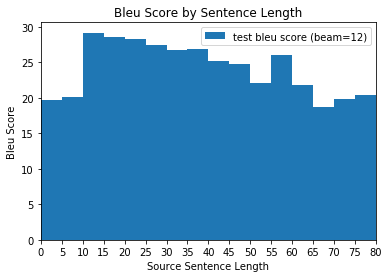

In [58]:
if length_bleu_test:
    plot_bleu_score_by_sentence_length(length_bleu_test, 
                                       'test bleu score (beam=12)', 
                                       'Bleu Score by Sentence Length')

Sutskever does not provide data on their non-ensemble model performance by sentence length. However, they do provide this data for their ensemble model. In those results, they found that performance did not drop until exceeding a sentence length of 35 words. Here, we find performance begins to gradually drop off after 15 words. This is not an apples to apples comparison though. It would be interesting to know if using an ensemble not only improves the average performance, but also keeps performance more consistent as sentence lengths grow.

### Final average BLEU score comparison

In [59]:
if epoch_beam_bleu_dev and epoch_beam_bleu_test:
    ntst1213_bleu_score = list(filter(lambda x: x[1] == 12, epoch_beam_bleu_dev))[-1][-1]
    ntst14_b1_bleu_score = list(filter(lambda x: x[1] == 1, epoch_beam_bleu_test))[-1][-1]
    ntst14_b12_bleu_score = list(filter(lambda x: x[1] == 12, epoch_beam_bleu_test))[-1][-1]
    display(HTML('<table>{}</tbody></table>'.format(
        '<thead><tr><th>Method</th><th>test BLEU score (ntst14)</th></tr></thead><tbody><tr>{}</tr>'.format(
            '</tr><tr>'.join(
                ['<td>Sutskever et al. single forward LSTM, beam size 12</td><td>26.17</td>',
                 '<td>Sutskever et al. single reversed LSTM, beam size 12</td><td>30.59</td>',
                 '<td>This implementation of single reversed LSTM, beam size 1</td><td>{}</td>',
                 '<td><b>This implementation of single reversed LSTM, beam size 12</b></td><td><b>{}</b></td>'
                     ]).format(ntst14_b1_bleu_score, ntst14_b12_bleu_score)))))

Method,test BLEU score (ntst14)
"Sutskever et al. single forward LSTM, beam size 12",26.17
"Sutskever et al. single reversed LSTM, beam size 12",30.59
"This implementation of single reversed LSTM, beam size 1",24.05
"This implementation of single reversed LSTM, beam size 12",26.76


As can be seen above, the implementation provided here under-performs Sutskever noticeably. In particular, our model produces results with reversed source sentences only slightly better than Sutskever's with non-reversed source sentences, and nearly 4 points less than Sutskever's with reversed source sentences. This might be due to the modifications made to the model, such as reducing the vocabulary size, and further compounded by not retuning the hyperparameters, such as the learning rate, accordingly.

## References

1. Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. 2014. Neural machine translation by jointly learning to align and translate. [arXiv:1409.0473](https://arxiv.org/abs/1409.0473).

2. Welin Chen, David Grangier, Michael Auli. 2015. Strategies for Training Large Vocabulary Neural Language Models. [arXiv:1512.04906](https://arxiv.org/abs/1512.04906).

3. Liang Huang and Kai Zhao and Mingbo Ma. 2017. When to Finish? Optimal Beam Search for Neural Text Generation (modulo beam size). _EMNLP_.

4.  H. Schwenk. University le mans. http://www-lium.univ-lemans.fr/˜schwenk/cslm_joint_paper/, 2014. \[Online; accessed 01-May-2018\].

5. Ilya Sutskever, Oriol Vinyals, Quoc V. Le. 2014. Sequence to Sequence Learning with Neural Networks. [arXiv:1409.3215v3](https://arxiv.org/abs/1409.3215v3).

6. George Kingsley Zipf. 1949. Human behavior and the principle of least effort.

7. mosesdecoder. Github Repository, https://github.com/moses-smt/mosesdecoder. \[Online; accessed 01-May-2018\].